In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
from tqdm.notebook import trange
from torch.utils.data import TensorDataset, DataLoader
from skimage.draw import polygon

device = "cuda" if torch.cuda.is_available() else "cpu"

(0.0, 0.13298076)

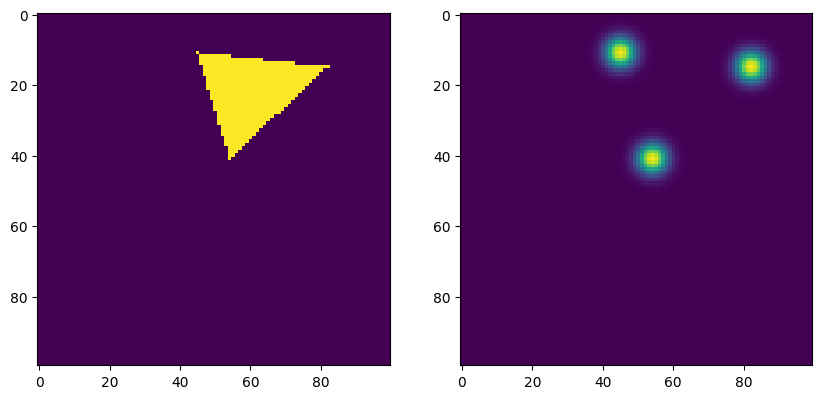

In [14]:
def generate_random_triangle(rows: int, columns: int) -> tuple[np.ndarray, np.ndarray]:
    sigma = 3
    image = np.zeros((rows, columns), dtype=np.float32)
    labels = np.zeros((rows, columns, 3), dtype=np.float32)
    xx, yy = np.arange(rows), np.arange(columns)
    mesh_xx, mesh_yy = np.meshgrid(xx, yy)
    r = np.random.randint(0, rows, 3)
    c = np.random.randint(0, rows, 3)
    r = np.append(r, r[0])
    c = np.append(c, c[0])
    rr, cc = polygon(r, c)
    image[rr, cc] = 1
    labels[:, :, 0] = np.exp(
        -((mesh_yy - r[0]) ** 2 + (mesh_xx - c[0]) ** 2) / (2 * sigma**2)
    ) / (sigma * np.sqrt(2 * np.pi))
    labels[:, :, 1] = np.exp(
        -((mesh_yy - r[1]) ** 2 + (mesh_xx - c[1]) ** 2) / (2 * sigma**2)
    ) / (sigma * np.sqrt(2 * np.pi))
    labels[:, :, 2] = np.exp(
        -((mesh_yy - r[2]) ** 2 + (mesh_xx - c[2]) ** 2) / (2 * sigma**2)
    ) / (sigma * np.sqrt(2 * np.pi))
    labels = np.sum(labels, axis=2)
    return image, labels


n_rows, n_columns = 100, 100
img, labels = generate_random_triangle(n_rows, n_columns)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img)
ax[1].imshow(labels)
np.min(labels), np.max(labels)

In [3]:
def generate_set(
    num_images: int, n_rows: int, n_columns: int
) -> tuple[torch.Tensor, torch.Tensor]:
    x, y = zip(
        *[generate_random_triangle(n_rows, n_columns) for i in range(num_images)]
    )
    x = torch.from_numpy(np.asarray(x)).unsqueeze(1)
    y = torch.from_numpy(np.asarray(y)).unsqueeze(1)
    return x, y


x_train, y_train = generate_set(200, n_rows, n_columns)
x_validation, y_validation = generate_set(50, n_rows, n_columns)
x_test, y_test = generate_set(10, n_rows, n_columns)
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)
print(x_test.shape, y_test.shape)

torch.Size([200, 1, 100, 100]) torch.Size([200, 1, 100, 100])
torch.Size([50, 1, 100, 100]) torch.Size([50, 1, 100, 100])
torch.Size([10, 1, 100, 100]) torch.Size([10, 1, 100, 100])


In [4]:
filters = 3


class TrianglesCNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = torch.nn.Sequential(
            nn.Conv2d(1, filters * 2, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(filters * 2, filters * 4, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(filters * 4, filters * 2, kernel_size=3, padding="same"),
            nn.ReLU(),
            convT1 := nn.ConvTranspose2d(
                filters * 2, filters * 2, kernel_size=3, stride=2, padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(filters * 2, filters * 2, kernel_size=3, padding="same"),
            nn.ReLU(),
            convT2 := nn.ConvTranspose2d(filters * 2, 1, kernel_size=4, stride=2),
            nn.ReLU(),
        )
        torch.nn.init.xavier_normal_(convT1.weight)
        torch.nn.init.xavier_normal_(convT2.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


net = TrianglesCNN().to(device)
optim = torch.optim.Adam(net.parameters(), 0.001)
loss_func = torch.nn.MSELoss()


train_loader = DataLoader(TensorDataset(x_train, y_train), 10, True)

In [5]:
net.train()
train_losses: list[float] = []
val_losses: list[float] = []
for epoch in trange(300):
    for x, y in train_loader:
        out = net(x.to(device))
        loss = loss_func(out, y.to(device))
        optim.zero_grad()
        loss.backward()
        optim.step()
    train_losses.append(loss.item())
    val_losses.append(
        loss_func(net(x_validation.to(device)), y_validation.to(device)).item()
    )

  0%|          | 0/300 [00:00<?, ?it/s]

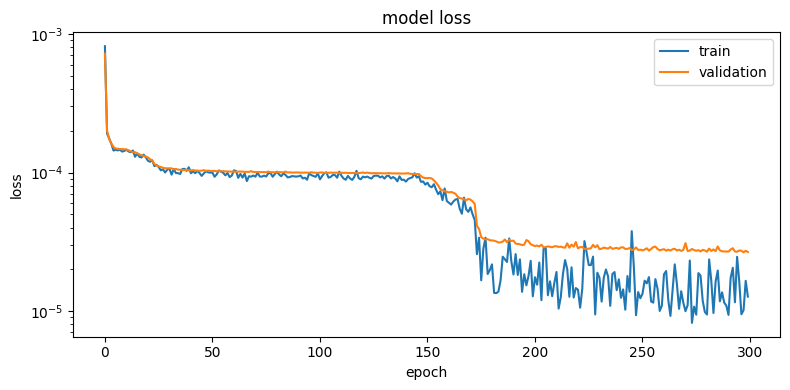

In [6]:
fig, axes = plt.subplots(figsize=(8, 4))
axes.plot(train_losses, label="train")
axes.plot(val_losses, label="validation")
axes.set(title="model loss", ylabel="loss", xlabel="epoch", yscale="log")
axes.legend()
fig.tight_layout()

In [10]:
test_loss = loss_func(net(x_test.to(device)), y_test.to(device)).item()
print("test_acc:", test_loss)

test_acc: 4.3981766793876886e-05


In [8]:
labels_predict = net(x_test.to(device)).numpy(force=True)
print(labels_predict.shape, labels.max())

(10, 1, 100, 100) 0.25197718


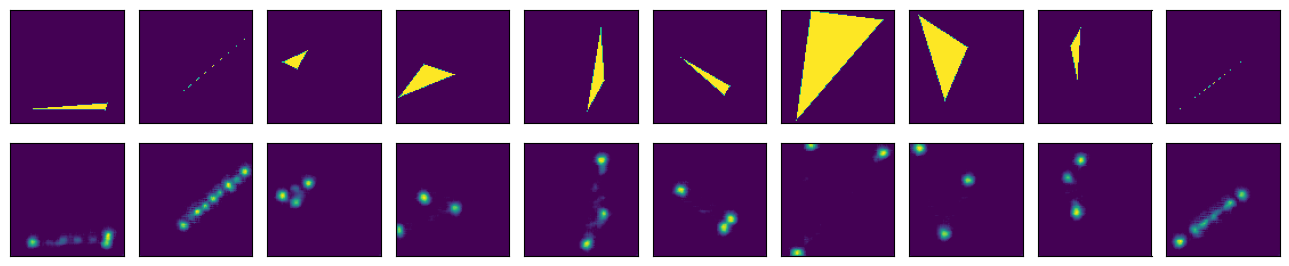

In [9]:
fig, axes = plt.subplots(2, 10, figsize=(13, 3))
for i in range(10):
    axes[0, i].imshow(x_test[i][0])
    axes[1, i].imshow(labels_predict[i][0])
    axes[1, i].set(yticks=(), xticks=())
    axes[0, i].set(yticks=(), xticks=())
fig.tight_layout()